# Sentiment Analysis for Amazon Food Reviews Using NLTK and Transformers

## Data Loading and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Reading the data

df = pd.read_csv("Reviews.csv")

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [5]:
df.shape

(568454, 10)

In [6]:
df = df.head(2000)

In [7]:
df.shape

(2000, 10)

## Exploratory Data Analysis

In [8]:
df['Score']

0       5
1       1
2       4
3       2
4       5
       ..
1995    5
1996    5
1997    4
1998    4
1999    5
Name: Score, Length: 2000, dtype: int64

In [9]:
df.Score.value_counts()

Score
5    1303
4     254
1     178
3     162
2     103
Name: count, dtype: int64

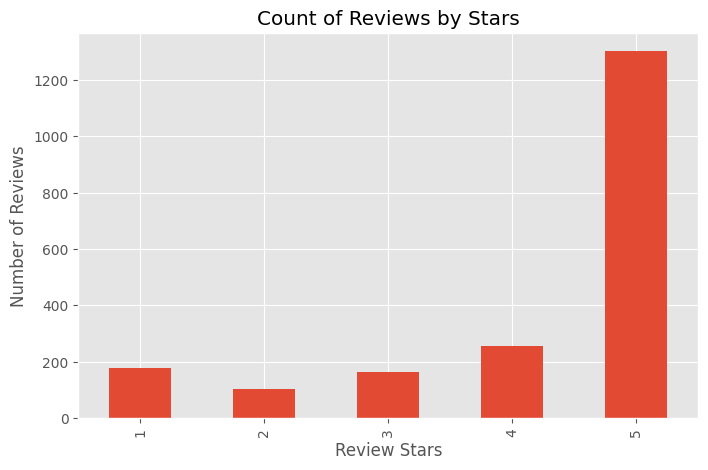

In [10]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', figsize=(8, 5))
ax.set_xlabel('Review Stars')
ax.set_ylabel('Number of Reviews')
plt.show()

## Basic NLTK

In [11]:
example = df['Text'][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [12]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [13]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [14]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Sentiment Scoring

We will use NLTK's **SentimentIntensityAnalyzer** to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
  1. Stop words are removed.
  2. Each word is scored and combined to a total score.

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [17]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [18]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [19]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T

In [21]:
vaders

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
1996,0.000,0.754,0.246,0.9744
1997,0.025,0.744,0.231,0.9978
1998,0.000,0.719,0.281,0.9501
1999,0.053,0.839,0.108,0.7003


In [22]:
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [23]:
# Got Sentiment Score and Metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## **PLOT VADER RESULTS**

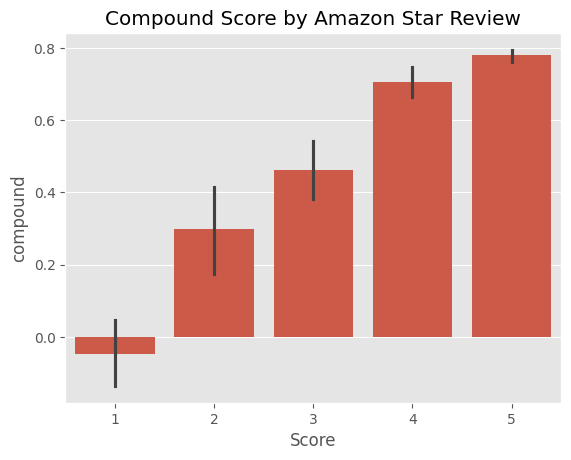

In [24]:
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

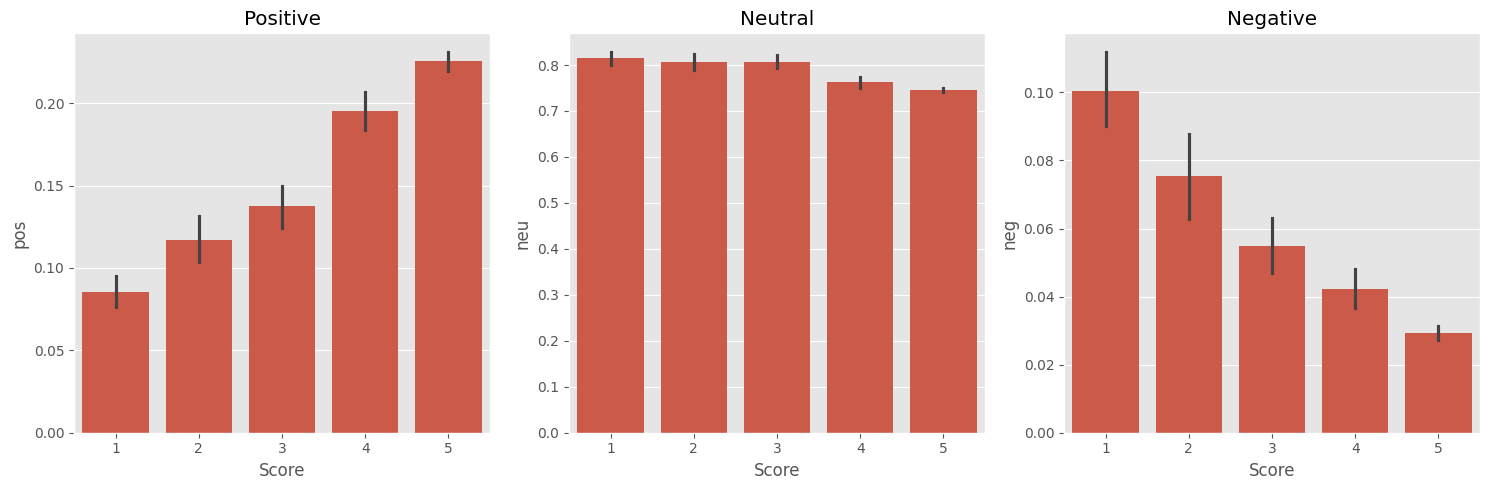

In [25]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data=vaders, x='Score', y='pos', ax = axs[0])
sns.barplot(data=vaders, x='Score', y = 'neu', ax = axs[1])
sns.barplot(data=vaders, x='Score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

#

# Step 2. Roberta Pretrained Model
  1. use a model tained of a large corpus of data.
  2. Transformer model accounts for the words but also the context related to other words

In [26]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [27]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [28]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [29]:
# Run the Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.97635514), 'roberta_neu': np.float32(0.020687463), 'roberta_pos': np.float32(0.0029573708)}


In [30]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [31]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    res[myid] = both

  except RuntimeError:
    print(f"broke for the id {myid}")

  0%|          | 0/2000 [00:00<?, ?it/s]

broke for the id 83
broke for the id 187
broke for the id 529
broke for the id 540
broke for the id 746
broke for the id 863
broke for the id 1053
broke for the id 1070
broke for the id 1156
broke for the id 1321
broke for the id 1375
broke for the id 1498
broke for the id 1575
broke for the id 1796
broke for the id 1826


In [32]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# **Compare Scores Between Models**

In [33]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

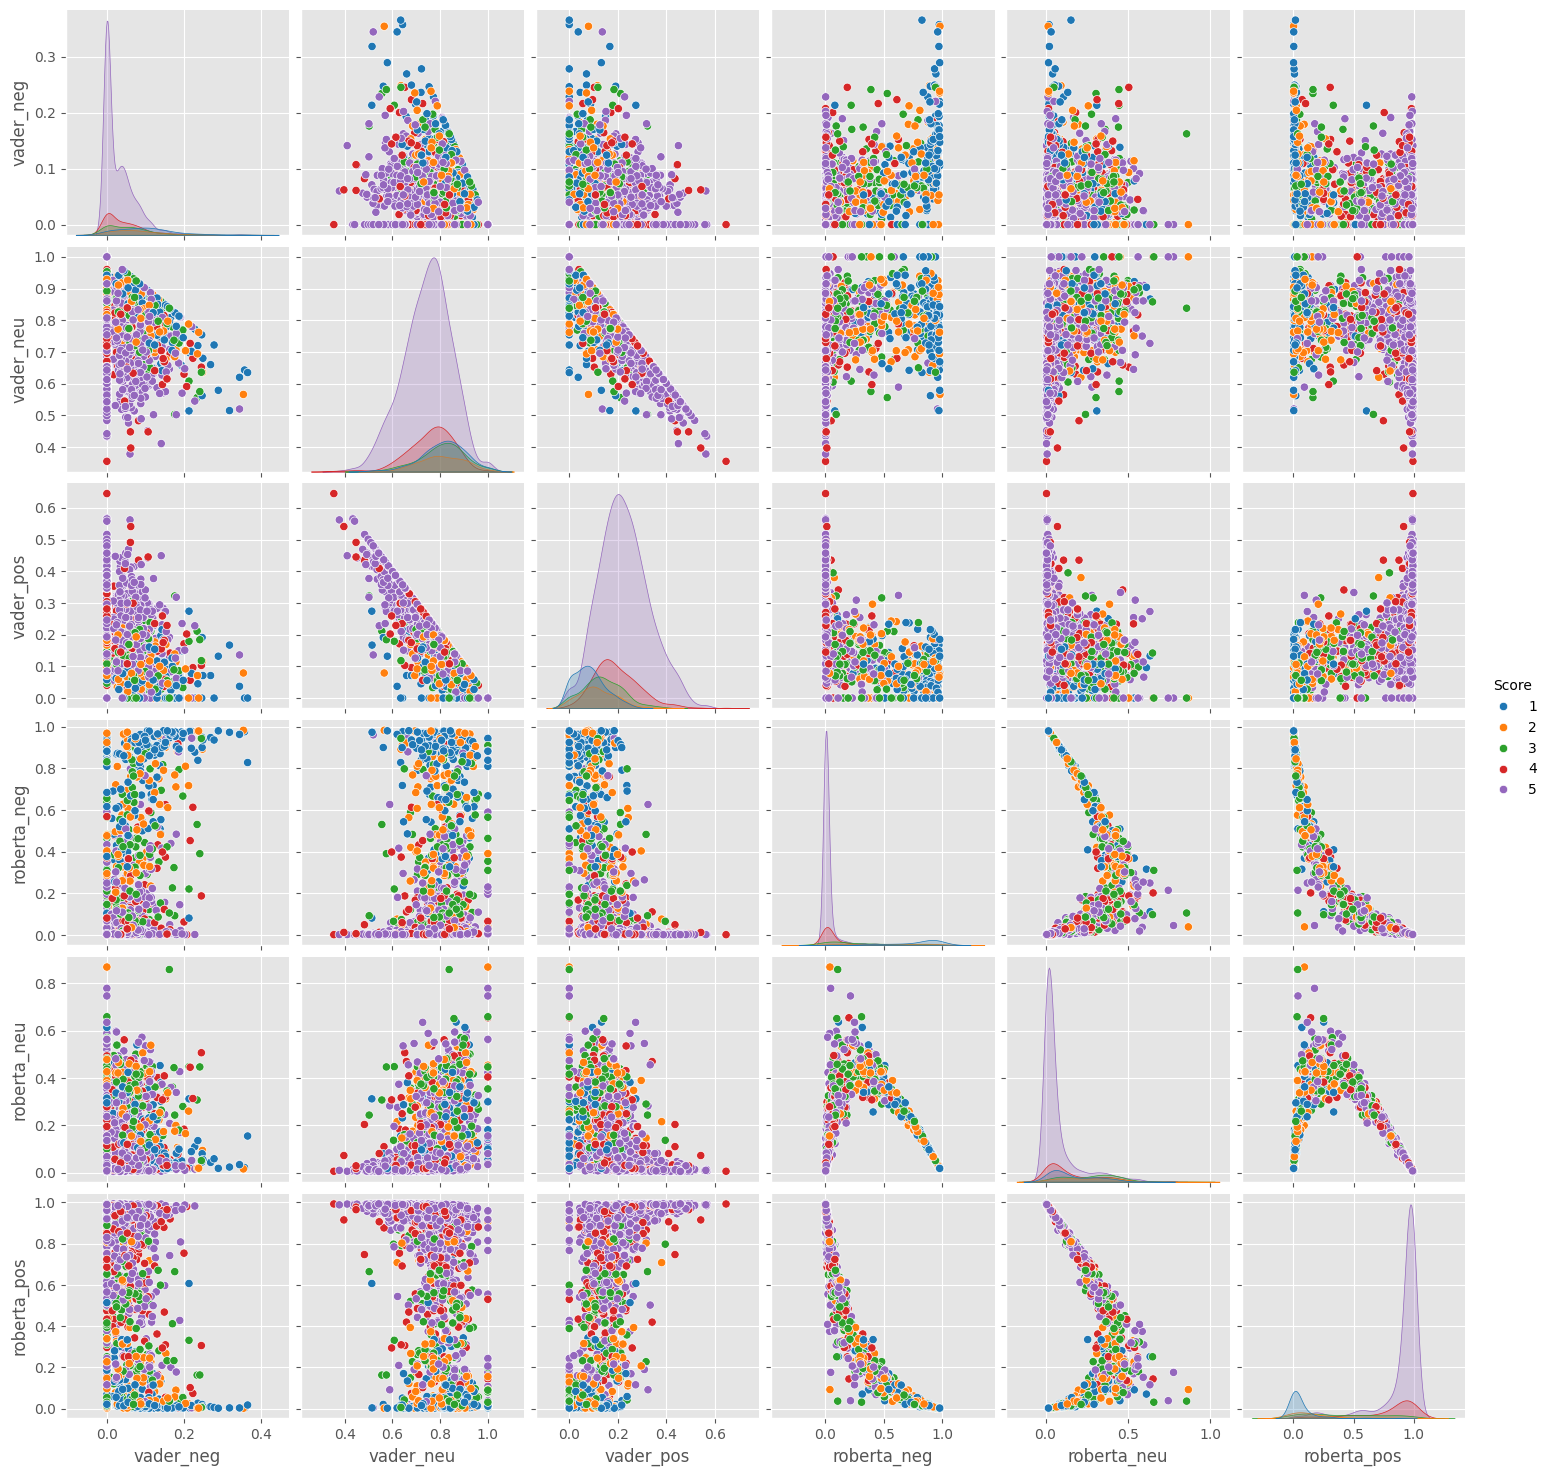

In [34]:
sns.pairplot(data = results_df,
             vars = ['vader_neg', 'vader_neu', 'vader_pos',
                     'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = 'Score',
             palette = 'tab10')
plt.show()

## Step3:  Review Some of the Examples:
 ### 1. Positive 1-Star and Negative 5-Star Reviews :->

 ### ***Lets look at some of the examples where model scoring and review score differ the most***

In [35]:
results_df.query('Score == 1') \
.sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [36]:
results_df.query('Score == 5') \
.sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [37]:
# Negative Sentiment 5-star view

results_df.query('Score == 5') \
.sort_values('vader_neg', ascending=False)[['Id', 'Score', 'Text']].head()

,Id,Score,Text
69,70,5,this was sooooo deliscious but too bad i ate e...
656,661,5,"I love using this to sweeten tea, coffee, etc...."
743,749,5,"If this flavor lasted longer than it does, I'd..."
1912,1928,5,I bought one of these about 4 or 5 months ago ...
1934,1950,5,If you like Bloody Mary 's and dirty martinies...


In [38]:
results_df.query('Score == 1') \
.sort_values('vader_pos', ascending=False)[['Id', 'Score', 'Text']].head()

,Id,Score,Text
322,325,1,So we cancelled the order. It was cancelled w...
1370,1382,1,This was my favorite stevia product and I had ...
1284,1294,1,This was very pricey for what is essentially a...
507,510,1,"Kettle chips now look, feel and taste like Lay..."
1102,1111,1,These had heat and had good enough coating of ...


# **Can Also Use Transformers Pipeline**

In [39]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",  model="distilbert-base-uncased-finetuned-sst-2-english")

Device set to use mps:0


In [40]:
sent_analysis = sentiment_pipeline(df['Text'].tolist(), truncation=True)

In [41]:
sent_analysis[0]["label"]

'POSITIVE'

In [42]:
All_Positive_Reviews = []
All_Negative_Reviews = []
for i,result in enumerate(sent_analysis):
    if result['label'] == 'POSITIVE':
        All_Positive_Reviews.append(result)
    else:
        All_Negative_Reviews.append(result)
        

In [43]:
num_positive = len(All_Positive_Reviews)
num_negative = len(All_Negative_Reviews)

avg_positive_score = sum([result['score'] for result in All_Positive_Reviews]) / num_positive
avg_negative_score = sum([result['score'] for result in All_Negative_Reviews]) / num_negative

print(f"Positive Reviews: {num_positive}, Avg Score: {avg_positive_score}")
print(f"Negative Reviews: {num_negative}, Avg Score: {avg_negative_score}")


Positive Reviews: 1405, Avg Score: 0.9817971227007829
Negative Reviews: 595, Avg Score: 0.9564589994294302


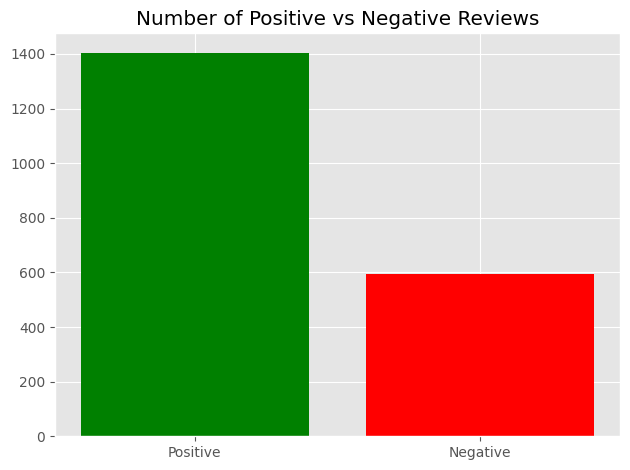

In [44]:
import matplotlib.pyplot as plt

labels = ['Positive', 'Negative']
counts = [num_positive, num_negative]


plt.bar(labels, counts, color = ['green', 'red'])
plt.title('Number of Positive vs Negative Reviews')
plt.tight_layout()
plt.show()

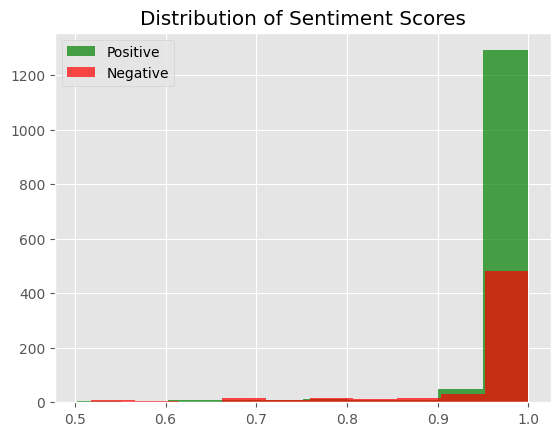

In [45]:
positive_scores = [result['score'] for result in All_Positive_Reviews]
negative_scores = [result['score'] for result in All_Negative_Reviews]

plt.hist(positive_scores, bins=10, alpha=0.7, label='Positive', color='green')
plt.hist(negative_scores, bins=10, alpha=0.7, label='Negative', color='red')
plt.title('Distribution of Sentiment Scores')
plt.legend()
plt.show()
